<a href="https://colab.research.google.com/github/LeandroCoelhos/Modelo_Churn_Funcionario/blob/main/Churn_de_Funcion%C3%A1rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Churn de Funcionário

#**Introdução**

De uma forma geral, Churn pode ser entendido como o de desligamento entre o cliente e uma empresa. A perda de um cliente nunca é bom para um empresa, e poder prever quando isso ocorrerá traz muitas vantagens tanto para empresa, que pode se planejar para essa perda, quanto para o cliente, que pode ser ofertado planos para que ele permaneça, ou fazer acordo para sua saída em definitivo. Este último se aplica somente em algumas situações específicas.

Tentaremos prever a saída dos funcionários da empresa ou a sua permanência no período dos proximos dois anos, a partir da coleta desses dados. Está nem sempre é uma tarefa facil, pois são muitas as variáveis que levam um funcionário a sair de uma empresa, mas através dos dados, tentaremos buscar alguns indicadores que tendem a fazer com que um funcionário deixe a empresa.

#Bibliotecas e Importação dos Dados



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics#ver redundancia

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

#from catboost import CatBoostClassifier

import missingno as missing

#Importando o conjunto de dados fornecido

O conjundo Treino será utilizado para o treinamento dos nossos modelos, ele contem a variável de interesse "Saiu", que tentaremos predizer no conjunto de dados de Teste, que não contem essa informação.

In [2]:
url1 = 'https://raw.githubusercontent.com/LeandroCoelhos/Modelo_Churn_Funcionario/main/data/treino_6.csv'
url2 = 'https://raw.githubusercontent.com/LeandroCoelhos/Modelo_Churn_Funcionario/main/data/teste_6.csv'

treino = pd.read_csv(url1)
teste = pd.read_csv(url2)

#Análise Exploratória



Verificando se há valores nulos e tipos de colunas

In [3]:
print("Valores no Conjunto de TREINO:\n")
print(treino.info())

Valores no Conjunto de TREINO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Escolaridade  2916 non-null   object
 1   Entrada       2916 non-null   int64 
 2   Cidade        2916 non-null   object
 3   Salário       2916 non-null   int64 
 4   Idade         2916 non-null   object
 5   Sexo          2916 non-null   object
 6   Projeto       2916 non-null   object
 7   Experiência   2916 non-null   int64 
 8   Saiu          2916 non-null   int64 
 9   Feedbacks     2916 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 227.9+ KB
None


In [4]:
print("Valores no Conjunto de TESTE:\n")
print(teste.info())

Valores no Conjunto de TESTE:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1737 entries, 0 to 1736
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Escolaridade  1737 non-null   object
 1   Entrada       1737 non-null   int64 
 2   Cidade        1737 non-null   object
 3   Salário       1737 non-null   int64 
 4   Idade         1737 non-null   object
 5   Sexo          1737 non-null   object
 6   Projeto       1737 non-null   object
 7   Experiência   1737 non-null   int64 
 8   Feedbacks     1737 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 122.3+ KB
None


O comando "info" mostra o total de observações em cada coluna, bem como o tipo de dado daquela coluna, se é numérico ou texto.

Para o conjunto de treinamento temos 2916 linhas, com 10 colunas, sem nenhum dado faltante segundo essa contagem.

Podemos ver que existem colunas com dados do tipo numéricos (int64) e campos de texto (objct). Este último, não é suportado por muitos algoritimos de ML, então precisaremos trata-lô posteriormente.

Note também, que a coluna Idade está sendo interpretada como texto, precisamos olhar mais de perto o que esta acontecendo.


Vizualizando o conjunto de dados

In [5]:
treino.head()

,Escolaridade,Entrada,Cidade,Salário,Idade,Sexo,Projeto,Experiência,Saiu,Feedbacks
0,Doutorado,2016,Natal,3,28,Feminino,Não,3,0,0
1,Doutorado,2014,Natal,3,36,Feminino,Não,3,0,1
2,Doutorado,2013,Natal,3,---,Masculino,Não,0,0,0
3,Doutorado,2016,Natal,3,---,Masculino,Não,2,1,0
4,Doutorado,2018,Natal,3,34,Masculino,Sim,5,1,0


In [6]:
teste.head()

,Escolaridade,Entrada,Cidade,Salário,Idade,Sexo,Projeto,Experiência,Feedbacks
0,Doutorado,2017,Recife,2,26,Masculino,Não,4,0
1,---,2017,Recife,3,26,Feminino,Não,4,0
2,Doutorado,2013,Natal,3,27,Masculino,Não,5,0
3,Doutorado,2014,Natal,3,26,Masculino,Não,4,0
4,Doutorado,2013,João Pessoa,2,---,Feminino,Não,0,0


Podemos ver o motivos da culuna idade ser classificada como object: existem algumas entradas com "--". Isso pode significar a falta de dados, veja que o mesmo acontece com a coluna de Escolaridade.

# Preparando uma vizualização automatizada para conjuntos categóricos e para conjuntos numéricos

Vamos criar uma maneira de separar as colunas numéricas das categóricas e fazer análises voltadas a cada tipo de variável.



In [7]:
coluna_numerica = treino.columns[treino.dtypes == "int64"] #Colunas de variáveis numericas
coluna_object = treino.columns[treino.dtypes == "object"] #Colunas do tipo numéricas

In [8]:
for i in treino.columns:
  print("Coluna: ",i)
  print(treino[i].value_counts(), "\n")

Coluna:  Escolaridade
Doutorado    2633
---           283
Name: Escolaridade, dtype: int64 

Coluna:  Entrada
2017    660
2015    504
2014    443
2013    423
2016    323
2012    320
2018    243
Name: Entrada, dtype: int64 

Coluna:  Cidade
Natal          1393
João Pessoa     816
Recife          707
Name: Cidade, dtype: int64 

Coluna:  Salário
3    2189
2     572
1     155
Name: Salário, dtype: int64 

Coluna:  Idade
26     406
27     391
28     389
25     260
24     238
---    159
29     135
30     130
36      81
38      80
32      77
34      74
35      70
40      70
33      69
39      66
37      66
31      65
41      39
22      30
23      21
Name: Idade, dtype: int64 

Coluna:  Sexo
Masculino    1752
Feminino     1164
Name: Sexo, dtype: int64 

Coluna:  Projeto
Não    2183
---     429
Sim     304
Name: Projeto, dtype: int64 

Coluna:  Experiência
2    673
4    599
5    579
3    497
1    339
0    222
7      4
6      3
Name: Experiência, dtype: int64 

Coluna:  Saiu
0    1820
1    1096

Como não sabemos as procedencias ou como foi deita a coleta dos dados, vamos interpretar para este problema que todos os campos '--' são dados faltantes, e os trataremos como tal.

Podemos observar que a coluna 'Escolaridade' existe apenas as categorias de 'Doutorado' e '--'. Isso nos indica que é uma coluna sem muita informação, pois conter uma unica categoria e dados faltantes não nos traz muitas informações. Devemos retirar essa coluna posteriormente.

Vamos ressaltar aqui a coluna 'Salário', que indica quanto o funcionario ganha, sendo as categorias** 1 > 2 > 3**, então temos a maior parte de nossos funcionarios com salarios baixos.


Para coluna 'Idade', também temos dados faltantes '--', e esse é o motivo dela ser interpretada pelo python como object ao inves de int. 
Notamos aqui que a maior parte de nossos funcionarios se encontram entre 24 e 30 anos, o que indica uma que muitos ainda são jovens, provavelmente em seu primeiro ou segundo emprego. Nessa faixa etária é comum a mudança de emprego.

Nossos funcionários são em sua maioria Homens.

Nossos dados indicam que a maioria nunca ficou sem prejetos, mesmo se incluissemos os dados faltantes.A coluna 'Projeto' indica se o funcionário já ficou mais de um mês sem atuar em nenhum projeto. 

A coluna 'Experiência' indica os anos de experiência de um funcionário. Nossos dados indicam que cerca de 20% deles tem 1 ano ou menos de experiência.

A coluna 'Feedback' indica quantas avaliações negativas um funcionário teve. Aqui vemos que grande parte nunca recebeu um feedback negativo.

Nossa coluna alvo 'Saiu' mostra que estamos lidando com um problema desbalanceado, onde existem mais funcionários que permaneceram em dois anos, dos que funcionários que sairam. 
Isso mostra que devemos nos ater a esse detalhe durante nossas análises, para não enviesarmos nossas conclusões.



#Vizualização Gráfica Categóricas

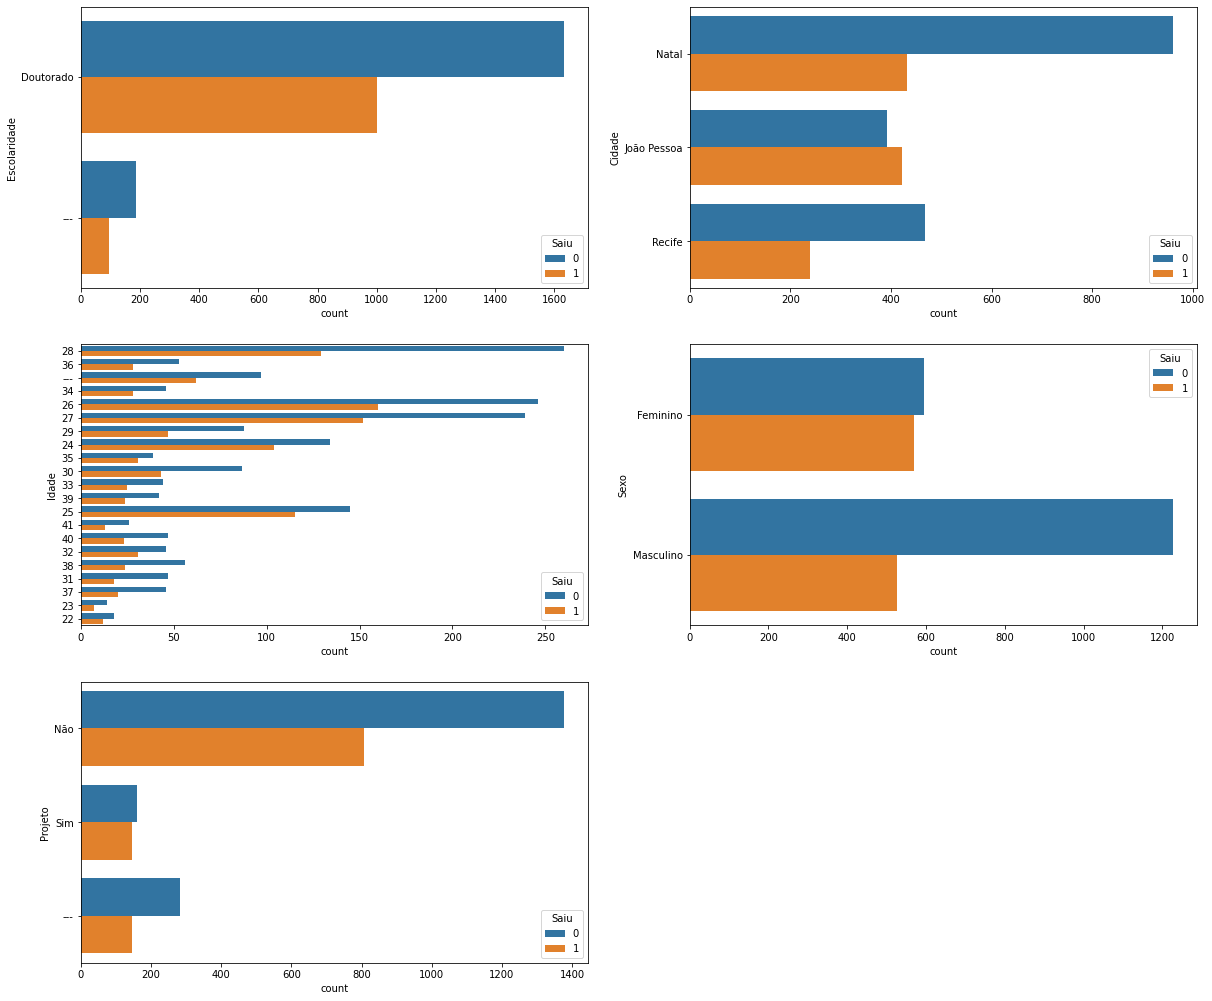

In [9]:
f, ax = plt.subplots(figsize=(20, 30))
for i in range(len(coluna_object)):
  plt.subplot(5,2,i+1)
  sns.countplot(data = treino, y=coluna_object[i], hue='Saiu')

Na análise gráfica podemos identificar algumas características que podem influenciar nosso funcionário a permanecer na empresa, como ser da cidade de Natal ou de João Pessoa, ter entre 26 e 28 anos e ser do sexo masculino. Todas essas são tendências de nosso funcionário permanecer na empresa, mas não são garantias e ainda não sabemos se essas características estão relacionadas.

#Vizualização gráfica numericas

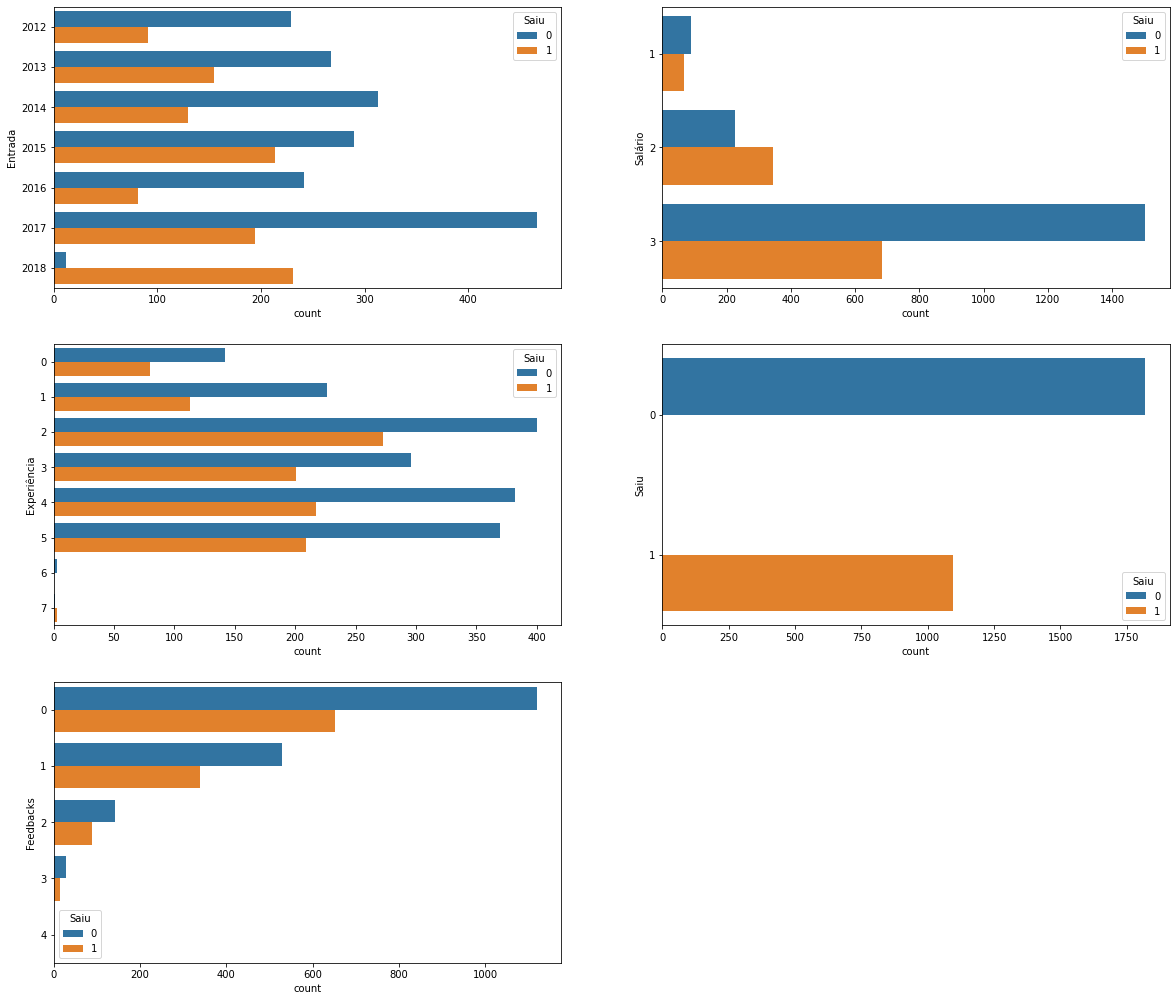

In [10]:
f, ax = plt.subplots(figsize=(20, 30))
for i in range(len(coluna_numerica)):
  plt.subplot(5,2,i+1)
  sns.countplot(data = treino, y=coluna_numerica[i], hue='Saiu')

Para as colunas numéricas, podemos identificar de cara que aqueles funcionários que entraram na empresa em 2018 tem uma grande propensão a deixar a empresa nos proximos dois anos. Isso representa quase 10% do total da nossa base.
Já nossos outros dados mostram uma tendência do nosso funcionário sair. Mas aqui devemos tomar muito cuidado, pois vale lembrar que estamos lidando com uma base de dados desbalanceada, e por isso é normal que alguns dados gráficos nos indiquem que mais clientes permeneceram do que sairam, pois é o viés que nossos dados tem. Todas os pontos levantados anterioemente foram com esse dado em mente.

#Substituindo valores faltantes

Vamos substituir os valores faltantes da coluna Idade pela parte inteira da Média.
Atribuiremos esse valor também ao conjunto de teste, substintituindo os valores faltantes pela média do conjunto de treino. 
> Em geral esse é um problema de vazamento de dados, onde estamos utilizando os dados de treinamento no nosso conjunto de testes. Na prática, isso não afeta tanto nossos resultados, e sendo um erro controlado, onde temos ciência de sua existencia.

Para a coluna 'Porjeto' substituiremos os valores faltantes pela moda. 

E descartaremos a coluna 'Escolaridade', então não precisamos mexer nos seus dados.

In [18]:
treino_media_idade = pd.to_numeric(treino[treino['Idade'] != '---']['Idade']).mean()#Pegando a média da coluna, sem contar os valores faltantes
treino_media_idade = int(treino_media_idade) #pegando a parte inteira do valor gerado

treino.Idade.replace('---', treino_media_idade, inplace=True)
treino.Idade = pd.to_numeric(treino.Idade)#transformando em uma coluna numérica
teste.Idade.replace('---', treino_media_idade, inplace=True)
teste.Idade = pd.to_numeric(teste.Idade)#o mesmo para o conjunto de teste

In [24]:
treino_moda_projeto = treino['Projeto'].mode()#Pegando moda da coluna Projeto

treino.Projeto.replace('---', treino_moda_projeto[0], inplace=True)
teste.Projeto.replace('---', treino_moda_projeto[0], inplace=True)

In [28]:
treino = treino.drop(['Escolaridade'], axis=1) 
teste = teste.drop(['Escolaridade'], axis=1) 

One-Hot-Encoding 

Nesta etapa vamos tranformar algumas colunas categórias em uma nova coluna para cada categoria. Isso nos garante a independência de cada categoria e uma maior clareza nos dados. Em contrapartida, essa abordagem pode acabar gerando mais dados a serem processados e uma maior complexidade das relações.

In [26]:
# realiza da dummificação das variáveis
treino = pd.get_dummies(treino, columns = ['Cidade', 'Entrada', 'Salário'], dtype=int)
teste = pd.get_dummies(teste, columns = ['Cidade', 'Entrada', 'Salário'], dtype=int)

Mapeando Colunas
Aqui vamos mapear algumas categorias para valores numéricos. Para colunas com apenas duas categorias, uma categoria será representada por 1 e outra por 0.

Vou aproveitar esse momento para inverter a ordinalidade da coluna Salário, onde as faixas de salários estão definidas como ' 1 > 2 > 3', irei inverter para que o salário 3, que é o menor seja representado por Zero.

In [25]:
treino['Sexo'] = treino['Sexo'].map({'Masculino': 0, 'Feminino':1})
treino['Projeto'] = treino['Projeto'].map({'Não': 0, 'Sim':1})
treino['Salário'] = treino['Salário'].map({3: 0, 2:1, 1:2})

teste['Sexo'] = teste['Sexo'].map({'Masculino': 0, 'Feminino':1})
teste['Projeto'] = teste['Projeto'].map({'Não': 0, 'Sim':1})
teste['Salário'] = teste['Salário'].map({3: 0, 2:1, 1:2})

Correlação de Colunas

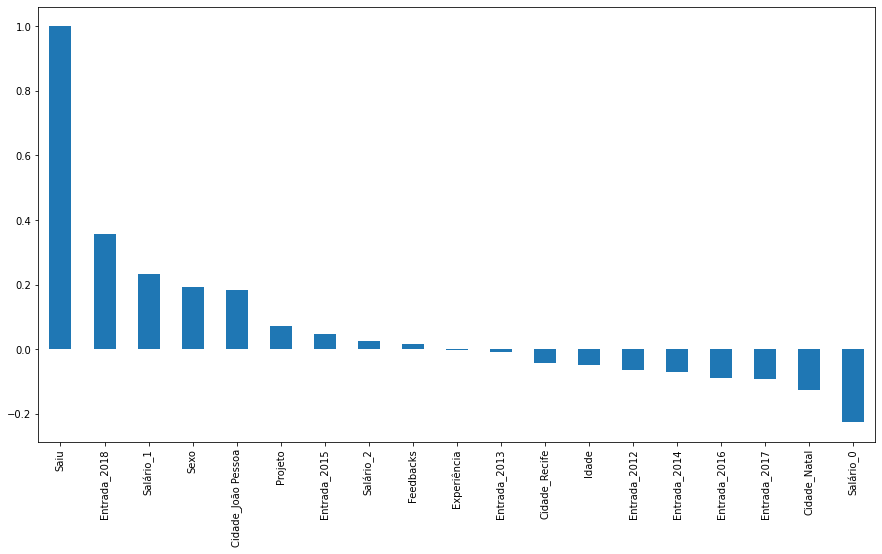

In [29]:
plt.figure(figsize=(15,8))
treino.corr()['Saiu'].sort_values(ascending = False).plot(kind='bar')

# Normalizando Valores

Muitos algorítimos são sensíveis com valores altos e com colunas possuindo escalas diferentes de valores. Por isso vamos tentar deixar todos os valores das colunas entre 0 e 1.

In [ ]:
treino['Idade'] = treino['Idade']/41
teste['Idade'] = teste['Idade']/41

treino['Feedbacks'] = treino['Feedbacks']/4
teste['Feedbacks'] = teste['Feedbacks']/4

treino['Experiência'] = treino['Experiência']/7
teste['Experiência'] = teste['Experiência']/7

# Métrica Alvo

O método de avaliar o desempenho do modelo escolhido foi o F1-Socre, que consiste de uma média harmônica entre a precisão e a sensibilidade (duas outras métricas).
O F1 é vantajoso em cenários com classes desbalanceadas e quando damos grande importância para os Falsos Negativos e Falsos Positivos, de forma que tentamos balancear o nosso modelo.

Aqui temos uma matriz de confusão, que indica os erros e os acertos do nosso modelo, comparando com o resultado esperado.

---
<img src="https://miro.medium.com/max/1876/1*s7VB26Cfo1LdVZcLou-e0g.png">

---
**Verdadeiro** é a predição correta do modelo. **Falso** é a precição errada do modelo.


>Sendo a _precision_:

$ precision = \frac{Vp}{Vp + Fp}$

>E o _recall_:  

$ recall = \frac{Vp}{Vp + Fn}$

Por fim o F1-Score:
$ F1 = 2.\frac{precision.recall}{precision + recall}$

# Método de Validação


Para validação cruzada do modelo, vamos utilizar o K-Fold Estratificado, com k igual a 10 e repetindo 10 vezes o método. Isso nos traz resultados mais estaveis e confiáveis, do que se rodassemos o modelo apenas uma vez.

O K-Fold separa o conjunto de dados K partes iguais, utilizando K-1 delas para treinamento e a parte K para validar (testar) o modelo. Repetindo o processo até que todas as K partições tenham sido utilizadas tanto para treinamento quanto para teste. 


In [ ]:
validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10)

# Testandos alguns modelos

Vamos testar uma gama de modelos e procurar aqueles que apresentam os melhores resultados.

Quando temos  recursos computacionais, essa abordagem nos ajuda a decidir os modelos a serem utilizados com base em todo conjunto de treino. O que para uma grande base de dados isso seria inviável, devido ao tempo de processamento de cada modelo.

Tunagem de Hiperparametros com GridSearch

Combinaçãod de Modelos

Conclusões

proximos Passos